In [1]:
import math
import pandas_datareader as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

plt.style.use('fivethirtyeight')

In [2]:
import pandas as pd

df = pd.read_csv ('combined_dataset_daily_TSLA_AAPL.csv')
df

,dt,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_AdjClose,TSLA_Volume,AAPL_Open,AAPL_High,AAPL_Low,...,DGS6MO,DGS10,BAMLH0A0HYM2,VXIBMCLS,USEPUINDXD,DCOILWTICO,TSLA_EPS_diluted,AAPL_EPS_diluted,TSLA_P/E,AAPL_P/E
0,2012-11-05,5.960000,6.316000,5.866000,6.300000,6.300000,10244500.0,20.840000,20.991785,20.628571,...,0.15,1.72,5.57,19.64,225.43,85.64,-0.7440,1.5772,-8.467742,13.238198
1,2012-11-06,6.122000,6.240000,5.990000,6.230000,6.230000,11620000.0,21.079643,21.097857,20.717501,...,0.15,1.78,5.49,19.60,195.50,88.62,-0.7440,1.5772,-8.373656,13.198117
2,2012-11-07,6.200000,6.410000,6.162000,6.308000,6.308000,8572500.0,20.494286,20.519285,19.848213,...,0.14,1.68,5.63,20.49,358.00,84.50,-0.7440,1.5772,-8.478495,12.635412
3,2012-11-08,6.202000,6.376000,6.188000,6.262000,6.262000,6370000.0,20.022499,20.079643,19.117500,...,0.15,1.62,5.67,20.85,241.14,85.07,-0.7440,1.5772,-8.416667,12.176868
4,2012-11-09,6.120000,6.186000,5.970000,6.064000,6.064000,4315000.0,19.300714,19.817142,19.061428,...,0.15,1.61,5.77,20.82,278.07,86.08,-0.7440,1.5772,-8.150538,12.387685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3547,2022-07-23,828.659973,842.359985,812.140015,816.729980,816.729980,34421200.0,155.389999,156.279999,153.410004,...,2.97,2.77,4.96,25.73,96.97,97.71,8.3024,6.1521,98.372757,25.046731
3548,2022-07-24,828.659973,842.359985,812.140015,816.729980,816.729980,34421200.0,155.389999,156.279999,153.410004,...,2.97,2.77,4.96,25.73,212.51,97.71,8.3024,6.1521,98.372757,25.046731
3549,2022-07-25,816.650024,822.440002,802.200012,805.299988,805.299988,21357800.0,154.009995,155.039993,152.279999,...,3.06,2.81,4.95,25.17,110.63,99.83,8.3024,6.1521,96.996048,24.861429
3550,2022-07-26,799.539978,801.929993,768.789978,776.580017,776.580017,22273600.0,152.259995,153.089996,150.800003,...,3.06,2.81,5.06,25.24,30.93,99.83,8.3024,6.1521,93.536811,24.641993


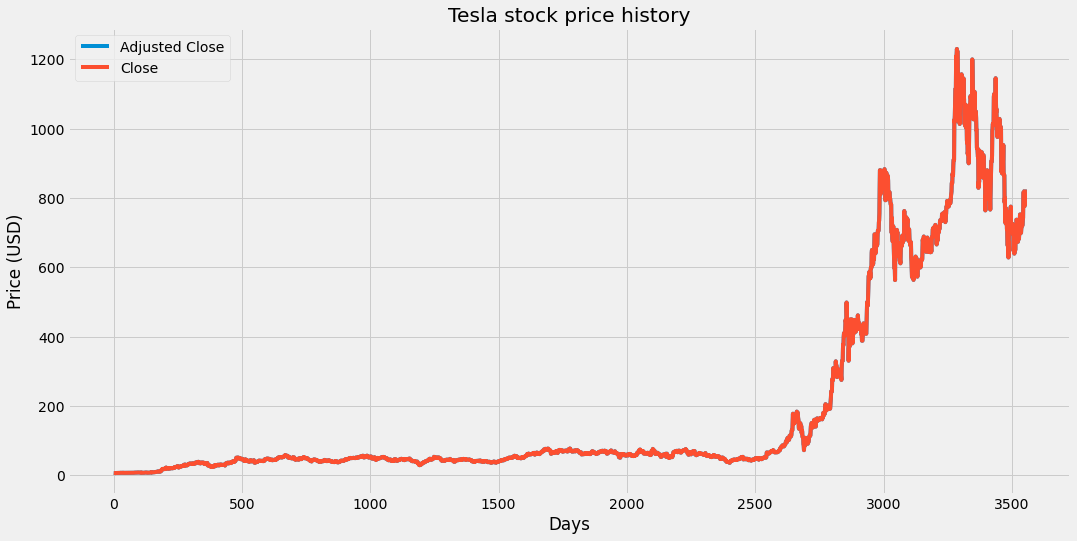

In [3]:
plt.figure(figsize = (16,8))
plt.plot(df["TSLA_AdjClose"])
plt.plot(df["TSLA_Close"])
plt.title('Tesla stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Adjusted Close','Close'], loc='upper left')
plt.show()

In [4]:
data = df.filter(['TSLA_Close'])
dataset = data.values
#Get number of rows to train the model on
training_data_len = math.ceil(len(dataset)* .8)

training_data_len

2842

In [5]:
#Scale the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[1.92834764e-04],
       [1.35637886e-04],
       [1.99371450e-04],
       ...,
       [6.53052725e-01],
       [6.29585745e-01],
       [6.68708317e-01]])

## Trying to predict using 60 days as timestep 

In [6]:
train_data = scaled_data[0:training_data_len  , : ]

x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()



[array([1.92834764e-04, 1.35637886e-04, 1.99371450e-04, 1.61785019e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.22564515e-04,
       2.10810747e-04, 1.73224317e-04, 8.17095467e-05, 2.48397178e-04,
       2.48397178e-04, 2.48397178e-04, 4.24890032e-04, 4.37963404e-04,
       3.51351245e-04, 3.51351245e-04, 2.95788832e-04, 2.95788832e-04,
       2.95788832e-04, 3.18667427e-04, 2.99056980e-04, 4.75549834e-04,
       5.50722695e-04, 5.71967216e-04, 5.71967216e-04, 5.71967216e-04,
       7.02702491e-04, 5.85040978e-04, 5.53991233e-04, 5.85040978e-04,
       6.29164094e-04, 6.29164094e-04, 6.29164094e-04, 6.94531731e-04,
       8.10559560e-04, 8.07291022e-04, 5.37649324e-04, 5.70333142e-04,
       5.70333142e-04, 5.70333142e-04, 6.66750524e-04, 6.97800269e-04,
       7.01068417e-04, 6.71653136e-04, 6.01382887e-04, 6.01382887e-04,
       6.01382887e-04, 6.47140077e-04, 6.47140077e-04, 5.34380786e-04,
       5.50722695e-04, 4.73915760e-04, 4.73915760e-04, 4.73915760e-04,
     

In [7]:
# converting into numpy sequences to train the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print('Number of rows and columns: ', x_train.shape)  

Number of rows and columns:  (2782, 60, 1)


In [8]:
x_train.shape

(2782, 60, 1)

In [9]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))

model.add(Dense(25))
model.add(Dense(1))



model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(x_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
87/87 [==============================] - 7s 36ms/step - loss: 1.9801e-04
Epoch 2/50
87/87 [==============================] - 3s 37ms/step - loss: 3.2841e-05
Epoch 3/50
87/87 [==============================] - 3s 38ms/step - loss: 2.7491e-05
Epoch 4/50
87/87 [==============================] - 3s 36ms/step - loss: 2.2287e-05
Epoch 5/50
87/87 [==============================] - 3s 37ms/step - loss: 1.9266e-05
Epoch 6/50
87/87 [==============================] - 3s 37ms/step - loss: 2.1165e-05
Epoch 7/50
87/87 [==============================] - 3s 38ms/step - loss: 1.9929e-05
Epoch 8/50
87/87 [==============================] - 3s 40ms/step - loss: 1.7998e-05
Epoch 9/50
87/87 [==============================] - 3s 37ms/step - loss: 1.7449e-05
Epoch 10/50
87/87 [==============================] - 3s 38ms/step - loss: 1.7156e-05
Epoch 11/50
87/87 [==============================] - 3s 36ms/step - loss: 1.3243e-05
Epoch 12/50
87/87 [==============================] - 3s 34ms/step - loss: 

In [10]:
# # We add the LSTM layer and later add a few Dropout layers to prevent overfitting.
# # Building a LTSM model with 50 neurons and 4 hidden layers. We add the LSTM layer with the following arguments:
# # 50 units which is the dimensionality of the output space
# # return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence input_shape as the shape of our training set.
# # When defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped.
# # Thereafter, we add the Dense layer that specifies the output of 1 unit.
# # After this, we compile our model using the popular adam optimizer and set the loss as the mean_squarred_error.

# model = Sequential()

# #Adding the first LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
# model.add(Dropout(0.2))

# # Adding a second LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a fourth LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# # Adding the output layer
# model.add(Dense(units = 1))

# # Compiling the RNN
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# # Fitting the RNN to the Training set
# model.fit(x_train, y_train, epochs = 50, batch_size = 32)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Getting the predicted stock price
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

# Convert x_test to a numpy array
x_test = np.array(x_test)


In [13]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
print('Number of rows and columns: ', x_test.shape)

Number of rows and columns:  (710, 60, 1)


In [14]:
# Making predictions using the test dataset
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [15]:
#Get rmse
#
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

38.06332196602403

In [16]:
#Mean Absolute Percentage Error - subtract from 100 and this is the accuracy? So like 97% which is pretty good
mape = np.mean(np.absolute((y_test- predictions)/y_test))* 100
mape

4.0180439363100025

<ipython-input-17-62e3b38ab0a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


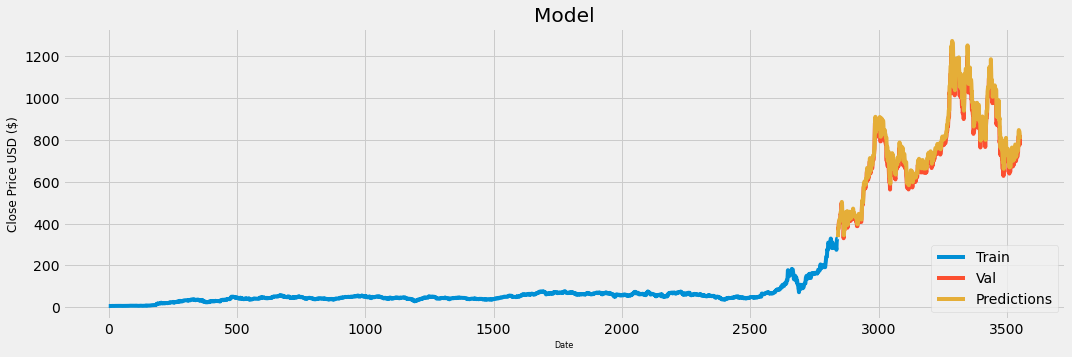

In [17]:
# Visualising the results
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,5))

plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['TSLA_Close'])
plt.plot(valid[['TSLA_Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [18]:
valid

,TSLA_Close,Predictions
2842,367.127991,335.576508
2843,377.417999,369.674652
2844,375.705994,385.336914
2845,400.365997,384.424042
2846,409.996002,406.019104
...,...,...
3547,816.729980,847.480713
3548,816.729980,843.275330
3549,805.299988,842.021851
3550,776.580017,831.660706


In [19]:
from sklearn.preprocessing import MinMaxScaler


In [20]:
#Try and predict closing price 
tsla_quote = web.DataReader('TSLA', data_source='yahoo', start = '2012-01-01', end = '2021-3-14')
new_df = tsla_quote.filter(['Close'])

#Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

[[720.8176]]


In [21]:
#Actaul closing
tsla_quote_actual = web.DataReader('TSLA', data_source='yahoo', start = '2012-01-01', end = '2021-3-15')
print(tsla_quote_actual['Close'])

Date
2012-01-03      5.616000
2012-01-04      5.542000
2012-01-05      5.424000
2012-01-06      5.382000
2012-01-09      5.450000
                 ...    
2021-03-09    673.580017
2021-03-10    668.059998
2021-03-11    699.599976
2021-03-12    693.729980
2021-03-15    707.940002
Name: Close, Length: 2314, dtype: float64


## Trying to predict using 180 days as timestep 

In [35]:
train_data = scaled_data[0:training_data_len  , : ]

x_train = []
y_train = []
for i in range(180, len(train_data)):
    x_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])
    if i<=180:
        print(x_train)
        print(y_train)
        print()



[array([1.92834764e-04, 1.35637886e-04, 1.99371450e-04, 1.61785019e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.22564515e-04,
       2.10810747e-04, 1.73224317e-04, 8.17095467e-05, 2.48397178e-04,
       2.48397178e-04, 2.48397178e-04, 4.24890032e-04, 4.37963404e-04,
       3.51351245e-04, 3.51351245e-04, 2.95788832e-04, 2.95788832e-04,
       2.95788832e-04, 3.18667427e-04, 2.99056980e-04, 4.75549834e-04,
       5.50722695e-04, 5.71967216e-04, 5.71967216e-04, 5.71967216e-04,
       7.02702491e-04, 5.85040978e-04, 5.53991233e-04, 5.85040978e-04,
       6.29164094e-04, 6.29164094e-04, 6.29164094e-04, 6.94531731e-04,
       8.10559560e-04, 8.07291022e-04, 5.37649324e-04, 5.70333142e-04,
       5.70333142e-04, 5.70333142e-04, 6.66750524e-04, 6.97800269e-04,
       7.01068417e-04, 6.71653136e-04, 6.01382887e-04, 6.01382887e-04,
       6.01382887e-04, 6.47140077e-04, 6.47140077e-04, 5.34380786e-04,
       5.50722695e-04, 4.73915760e-04, 4.73915760e-04, 4.73915760e-04,
     

In [36]:
# converting into numpy sequences to train the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print('Number of rows and columns: ', x_train.shape)  

Number of rows and columns:  (2662, 180, 1)


In [37]:
x_train.shape

(2662, 180, 1)

In [38]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(x_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
84/84 [==============================] - 13s 103ms/step - loss: 3.0030e-04
Epoch 2/50
84/84 [==============================] - 9s 107ms/step - loss: 2.6481e-05
Epoch 3/50
84/84 [==============================] - 10s 117ms/step - loss: 2.9806e-05
Epoch 4/50
84/84 [==============================] - 10s 122ms/step - loss: 2.4507e-05
Epoch 5/50
84/84 [==============================] - 12s 141ms/step - loss: 2.1433e-05
Epoch 6/50
84/84 [==============================] - 10s 120ms/step - loss: 2.3267e-05
Epoch 7/50
84/84 [==============================] - 10s 117ms/step - loss: 1.9927e-05
Epoch 8/50
84/84 [==============================] - 9s 108ms/step - loss: 2.0901e-05
Epoch 9/50
84/84 [==============================] - 9s 109ms/step - loss: 2.0366e-05
Epoch 10/50
84/84 [==============================] - 9s 113ms/step - loss: 2.5449e-05
Epoch 11/50
84/84 [==============================] - 12s 139ms/step - loss: 1.6512e-05
Epoch 12/50
84/84 [==============================] - 11s

In [39]:
# Getting the predicted stock price
test_data = scaled_data[training_data_len - 180: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len : , : ]
for i in range(180,len(test_data)):
    x_test.append(test_data[i-180:i,0])

# Convert x_test to a numpy array
x_test = np.array(x_test)


In [40]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
print('Number of rows and columns: ', x_test.shape)

Number of rows and columns:  (710, 180, 1)


In [41]:
# Making predictions using the test dataset
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [42]:
#Get rmse
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

32.536100525651094

In [43]:
#Mean Absolute Percentage Error
mape = np.mean(np.absolute((y_test- predictions)/y_test))* 100
mape

3.339758842815947

<ipython-input-46-6df6653f34d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


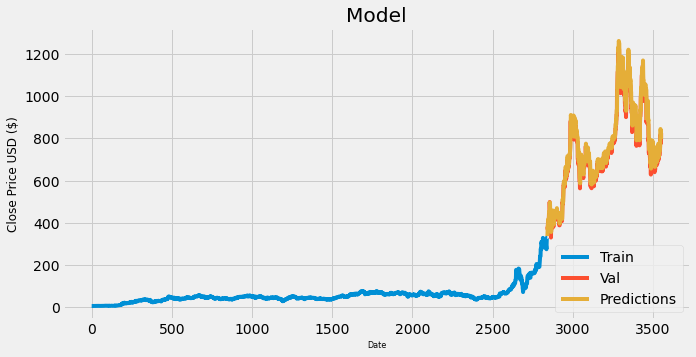

In [46]:
# Visualising the results
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(10,5))

plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['TSLA_Close'])
plt.plot(valid[['TSLA_Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [47]:
valid

,TSLA_Close,Predictions
2842,367.127991,337.240479
2843,377.417999,366.249176
2844,375.705994,383.806915
2845,400.365997,385.093842
2846,409.996002,403.393311
...,...,...
3547,816.729980,843.643127
3548,816.729980,841.070618
3549,805.299988,837.044556
3550,776.580017,825.043945


In [33]:
#Try and predict closing price 
tsla_quote = web.DataReader('TSLA', data_source='yahoo', start = '2012-01-01', end = '2021-12-16')
new_df = tsla_quote.filter(['Close'])

#Get the last 30 day closing price values and convert the dataframe to an array
last_30_days = new_df[-30:].values
last_30_days_scaled = scaler.transform(last_30_days)

X_test = []
X_test.append(last_30_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

[[950.92267]]


In [34]:
#Actaul closing
tsla_quote_actual = web.DataReader('TSLA', data_source='yahoo', start = '2012-01-01', end = '2021-12-17')
print(tsla_quote_actual['Close'])

Date
2012-01-03      5.616000
2012-01-04      5.542000
2012-01-05      5.424000
2012-01-06      5.382000
2012-01-09      5.450000
                 ...    
2021-12-13    966.409973
2021-12-14    958.510010
2021-12-15    975.989990
2021-12-16    926.919983
2021-12-17    932.570007
Name: Close, Length: 2508, dtype: float64
